# Remote server llm and data prompts

Imports

In [2]:
from ollama import Client
import tiktoken

import pandas as pd
import numpy as np

I've installed the ollama package via:

conda install conda-forge::ollama-python

In order to interact with a model we need to set it as our client. The model can be located on a the current machine or on a different machine, you just need to specify the host of the server via an IP. Below are two cases including a local and a remote server model. In either case the server is using port 11434. 

Local client: 
client = Client(host = "http://localhost:11434")

Remote client:
client = Client(host = "http://IP adress to host:Port at host")

I will continue with the remote server at NFA

In [ ]:

client = Client(host = "IP adress to host:Port")

Once the connection is established, we ready the data that we want the model to look at.

Here I load a csv file with combined data from two aerosol instruments (NS and OPS).
The dataset is quite big, so initially I drop unecessary columns to reduce its size, replace inf and -inf with nan values, and convert all numbers to integers, so we dont spend tokens on a lot of irrelevant decimals.

Finally, I convert the dataframe to a plan csv text for the model to deal with:

In [ ]:
# Load .csv files - I drop the datetime index column and some boolean columns to reduce size
data = pd.read_csv(r"data\NSOPS_NF.csv").drop(columns=['Datetime',"All data","Cutting","Break","Cleaning","Day1","Day2","Day3"])

# Replace any occurences of inf with nan and round all values to integers for more efficient use of tokens
data = data.replace([np.inf, -np.inf], np.nan)
num_cols = data.select_dtypes(include="number").columns
data[num_cols] = data[num_cols].round().astype("Int64")

# Convert it to a plain csv text for the model to read
csv_text = data.to_csv(na_rep="",index=False)

# Lets have a look at part of the data
print(csv_text[:1800])

Total_conc,11.5,15.4,20.5,27.4,36.5,48.7,64.9,86.6,115.5,154.0,205.4,268.6,337.0,419.5,522.0,650.0,809.0,1007.0,1254.0,1561.5,1944.0,2420.5,3014.0,3752.5,4672.0,5816.5,7241.0,9015.5
28395,1505,3875,4499,6007,5502,3625,1742,865,529,232,0,0,2,2,1,1,1,1,1,1,1,1,1,0,0,0,0,0
28561,1691,4122,4504,5875,5378,3577,1762,896,534,207,0,0,3,2,1,1,2,1,1,1,1,1,1,0,0,0,0,0
28233,1714,4099,4441,5834,5294,3454,1658,878,584,262,0,0,3,2,1,1,1,1,1,1,1,1,1,0,0,0,0,0
27244,1389,3789,4470,5614,5079,3440,1813,967,528,142,0,0,3,2,1,1,1,1,1,1,1,1,1,0,0,0,0,0
27475,1631,3873,4265,5534,5173,3584,1882,941,467,110,0,0,2,2,1,1,1,1,1,1,1,1,1,0,0,0,0,0
26952,1298,3563,4250,5603,5215,3585,1858,927,486,155,0,0,2,2,1,1,1,1,1,1,1,1,1,0,0,0,0,0
27629,1388,3737,4406,5783,5353,3642,1848,894,446,117,0,0,2,2,1,1,1,1,1,1,1,1,1,0,0,0,0,0
27612,1321,3705,4396,5769,5358,3666,1870,900,461,151,0,0,3,2,1,1,1,1,1,1,1,1,1,0,0,0,0,0
27056,1322,3378,4132,5810,5488,3709,1801,826,430,146,0,0,2,2,1,1,1,1,1,1,1,1,0,0,0,0,0,0
27246,1201,3378,4

Now that we have converted our data to plain text, we can imbed it into a prompt with some role and context information for the model to deal with.

In [7]:
full_input = [
    {
        "role": "system",
        "content": (
            "You are an expert in aerosol science and atmospheric particles. "
            "You specialize in analysis of particle concentration data from"
            "Nanoscan SMPS (NS) and optical particle counters (OPS). "
            "Always base your answer directly on the provided data and context."
        ),
    },
    {
        "role": "user",
        "content": (            
            "*CONTEXT*: The data below is from a measurement campaign in a glass wool "
            "production facility. Measurements were done during wedge cutting of "
            "glass wool mats using a Nanonscan SMPS (NS) and an optical particle "
            " counter (OPS). The datasets from each instrument have been combined into "
            "one.\n"
            "The first row is the header, while the seond row is the first measurements "
            "starting at 2023-10-23 13:46:00 and progress by one minute per datarow. "
            "The first data column is total number concentration followed by the "
            "concentration measured in each particle size bin - header is the particle "
            "size of the bin in nm.\n\n"

            "*TASK*: Based on this dataset:\n"
            "1. What does the particle data indicate about exposure?\n"
            "2. How do particle sizes vary with concentration and time?\n"
            "3. Do you observe time trends or sudden shifts? Describe them with approximate times.\n"
            "4. How do the levels compare to the OEL of 10 mg/m3?\n\n"

            f"DATA (CSV format):\n\n{csv_text}"
        ),
    },
]

Next we need to check the number of tokens used in the prompt to ensure that the model has sufficient context window to get the full prompt and still have room for reasoning and an answer. 

The gpt-oss 20B model has a max token number of 131,072 (according to chatgpt), but this includes input, output, and reasoining - so our prompt should be no more than half the token count.

I use a model to convert our prompt into plain text and use tiktoken to estimate the number of tokens within the prompt:

In [8]:
# Converts messages to a single string
def messages_to_text(messages):
    return "".join(
        f"{m['role']}:\n{m['content']}\n\n"
        for m in messages
    )

# Call the function
prompt_text = messages_to_text(full_input)

# Assess the number of tokens used:
enc = tiktoken.get_encoding("cl100k_base")
num_tokens = len(enc.encode(prompt_text))
print("Estimated tokens:", num_tokens)

Estimated tokens: 306137


The prompt is roughly 300k tokens but the gpt-oss model has a context window of roughly 130k, so we need to reduce the dataset e.g. by a factor of 10. 

We use a rolling median window and take every 10th datapoint before converting to plain text and embedding into the prompt again, which I also updated to reflect the datapoints being every 10 minutes instead of every minute:

In [9]:
data_downsampled = data.rolling(window=10, center=True, min_periods=1).median().iloc[::10]
csv_text = data_downsampled.to_csv(na_rep="",index=False)

# Now we also need to change the prompt text, as datapoint occur every 10 minutes instead of every minute.
new_full_input = [
    {
        "role": "system",
        "content": (
            "You are an expert in aerosol science and atmospheric particles. "
            "You specialize in analysis of particle concentration data from"
            "Nanoscan SMPS (NS) and optical particle counters (OPS). "
            "Always base your answer directly on the provided data and context."
        ),
    },
    {
        "role": "user",
        "content": (            
            "*CONTEXT*: The data below is from a measurement campaign in a glass wool "
            "production facility. Measurements were done during wedge cutting of "
            "glass wool mats using a Nanonscan SMPS (NS) and an optical particle "
            " counter (OPS). The datasets from each instrument have been combined into "
            "one.\n"
            "The first row is the header, while the seond row is the first measurements "
            "starting at 2023-10-23 13:46:00 and progress by ten minutes per datarow. "
            "The first data column is total number concentration followed by the "
            "concentration measured in each particle size bin - header is the particle "
            "size of the bin in nm.\n\n"

            "*TASK*: Based on this dataset:\n"
            "1. What does the particle data indicate about exposure?\n"
            "2. How do particle sizes vary with concentration and time?\n"
            "3. Do you observe time trends or sudden shifts? Describe them with approximate times.\n"
            "4. How do the levels compare to the OEL of 10 mg/m3?\n\n"

            f"DATA (CSV format):\n\n{csv_text}"
        ),
    },
]

Again we check the length of the prompt, just to be sure:

In [10]:
prompt_text = messages_to_text(new_full_input)
enc = tiktoken.get_encoding("cl100k_base")
num_tokens = len(enc.encode(prompt_text))
print("Estimated tokens:", num_tokens)

Estimated tokens: 59018


The new length is now roughly 59k tokens, which is well within the model limits and leaves room for reasoining and answer as well.

Now we can call the model and see its response... we increase its context window to its maximum of 131072 tokens - default is around 4k tokens and therefore not enough for this prompt.

In [ ]:
response = client.chat(
    model="gpt-oss",
    messages=new_full_input,
    options={"num_ctx": 131072},
)

print(response["message"]["content"]) # I have copied the response into a markdown cell below for an easier read

**1. What the data indicate about exposure**

The particle number concentration (NC) recorded at the start of the measurement period is very high – a total of **≈28 000 cm‑³** – but the bulk of the mass comes from particles larger than ~100 nm.  
Converting the number data into a mass concentration (assuming a density of 2.5 g cm‑³ for glass‐wool fibers) gives:

| Time | Total NC (cm‑³) | Approx. mass concentration (mg m‑³) |
|------|----------------|-----------------------------------|
| 13 : 46 | 28 233 | **≈0.009 mg m‑³** |
| 13 : 56 | 27 151 | **≈0.009 mg m‑³** |
| 14 : 06 | 26 537 | **≈0.008 mg m‑³** |
| 14 : 45 | 15 064 | **≈0.004 mg m‑³** |
| 15 : 32 |  8 462 | **≈0.001 mg m‑³** |
| 16 : 07 |  5 606 | **≈0.0006 mg m‑³** |

Even at the maximum the mass concentration is **≈0.009 mg m‑³**, more than **1 200 times** below the occupational exposure limit (OEL) of **10 mg m‑³**.  

> **Conclusion – Exposure is far below the OEL.**  
> The measured concentrations correspond to an essen

**1. What the data indicate about exposure**

The particle number concentration (NC) recorded at the start of the measurement period is very high – a total of **≈28 000 cm‑³** – but the bulk of the mass comes from particles larger than ~100 nm.  
Converting the number data into a mass concentration (assuming a density of 2.5 g cm‑³ for glass‐wool fibers) gives:

| Time | Total NC (cm‑³) | Approx. mass concentration (mg m‑³) |
|------|----------------|-----------------------------------|
| 13 : 46 | 28 233 | **≈0.009 mg m‑³** |
| 13 : 56 | 27 151 | **≈0.009 mg m‑³** |
| 14 : 06 | 26 537 | **≈0.008 mg m‑³** |
| 14 : 45 | 15 064 | **≈0.004 mg m‑³** |
| 15 : 32 |  8 462 | **≈0.001 mg m‑³** |
| 16 : 07 |  5 606 | **≈0.0006 mg m‑³** |

Even at the maximum the mass concentration is **≈0.009 mg m‑³**, more than **1 200 times** below the occupational exposure limit (OEL) of **10 mg m‑³**.  

> **Conclusion – Exposure is far below the OEL.**  
> The measured concentrations correspond to an essentially negligible mass exposure for operators, even during the most intense phase of the cutting operation.

---

**2. Size–concentration evolution over time**

* **Early phase (13 : 46 – 14 : 10)** – The size distribution is dominated by particles in the 20–50 nm range, with the 27.4 nm and 36.5 nm bins contributing > 50 % of the total number concentration.  
  - The 48.7 nm bin shows the largest single bin count (~3 600 cm‑³).  
  - A small tail (≤ 154 nm) is present but its contribution is < 10 % of the total NC.

* **Mid‑phase (14 : 20 – 15 : 00)** – Counts start to drop in all bins, but the relative shape remains similar: the 27–50 nm range still dominates.  
  - The 86–115 nm bins show a gradual increase (from ≈ 600 to ≈ 1 200 cm‑³) as the cutting mat becomes more fragmented.

* **Late phase (15 : 10 onward)** – The overall NC declines steeply; the 20–50 nm bins fall below 2 000 cm‑³.  
  - Larger bins (≥ 115 nm) become relatively more prominent, reflecting the accumulation of longer fibers and coarser dust.

Thus, **particle size distribution remains fairly constant in shape but the total concentration steadily decreases** as the cutting mat is consumed.

---

**3. Time‑trends and sudden shifts**

| Approx. time | Observed change | Interpretation |
|--------------|----------------|----------------|
| **13 : 46 – 13 : 56** | High NC, peak in 27–50 nm bins | First wedge cut, fresh fragmentation |
| **13 : 56 – 14 : 06** | Minor rise in 36–48 nm bins | Slight re‑excitation of fibers (re‑cutting or vibration) |
| **14 : 15 – 14 : 30** | Sudden spike in 115 nm bin (≈ 800 cm‑³) | Possible re‑cutting of a thicker layer or a change in cutting speed |
| **15 : 20 – 15 : 35** | Rapid drop in all bins | End of active cutting, dust settling |
| **16 : 00 onward** | Low, slowly varying NC | Post‑cutting background, mostly coarse fibers settling |

The most pronounced changes occur around **13 : 56** and **14 : 15**, consistent with moments when the cutter passes through a new section of the mat or when the cutting speed/angle changes.  After **15 : 30** the concentrations fall to background levels and remain stable.

---

**4. Comparison with the OEL of 10 mg m‑³**

| Time | Mass concentration (mg m‑³) | % of OEL |
|------|---------------------------|----------|
| 13 : 46 | 0.009 | 0.09 % |
| 13 : 56 | 0.009 | 0.09 % |
| 14 : 06 | 0.008 | 0.08 % |
| 14 : 45 | 0.004 | 0.04 % |
| 15 : 32 | 0.001 | 0.01 % |
| 16 : 07 | 0.0006 | 0.006 % |

Even during the peak of the cutting operation, the calculated mass concentration is **well below 1 % of the OEL**. Therefore, the measured exposure is **comfortably within the safety limits** for glass‑wool production workers.

---

### Key Take‑aways

* The **total particle concentration** peaks early in the cutting cycle but remains far below the mass‑based OEL.  
* The **size distribution** is dominated by particles 20–50 nm in diameter; larger fibers become more prominent only after the cutting mat is largely consumed.  
* **Sudden increases** in NC correlate with operational events (e.g., a new cut or speed change) and are brief.  
* **Mass concentrations** derived from the data are orders of magnitude lower than the 10 mg m‑³ OEL, indicating a low health risk from airborne glass‑wool fibers in this scenario.

### My take on the model output:

The model output is very detailed, and does have some relevant findings... however it has significant limits especially by the fact that larger particles are much more important than the smaller ones when it comes to mass concentration even if there is only one particle at 2 µm in size it outweighs 10 million particles of 20 nm...

# LLM for plot analysis

Here we quickly check the models ability to analyze plots via visual interpretation.

Initially we load a figure and convert it to bytes for the model to read:

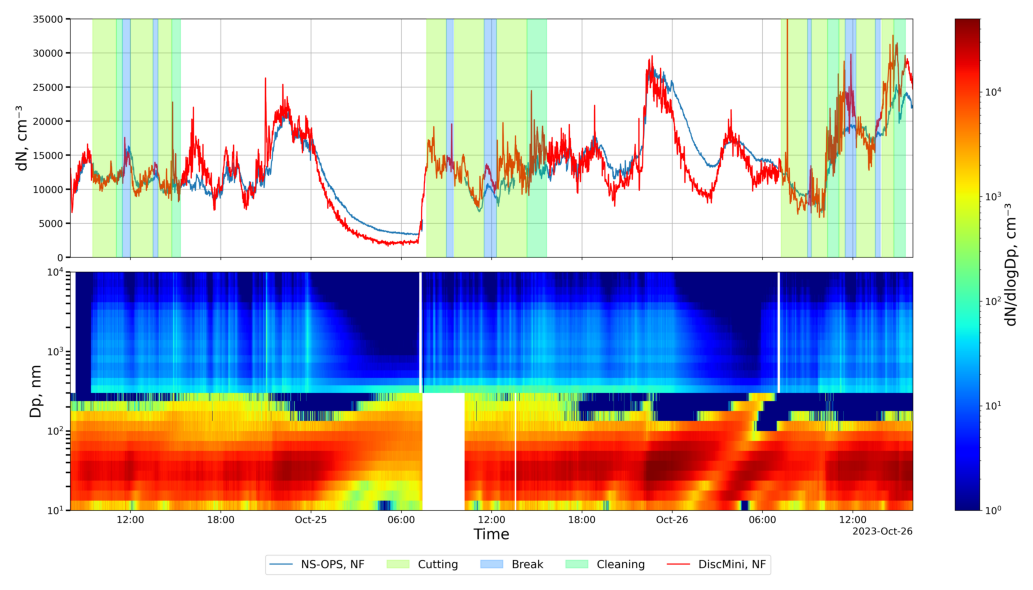

In [ ]:
from pathlib import Path
import io
from PIL import Image
import matplotlib.pyplot as plt

# We read the image as bytes for the model
img_bytes = Path(r"data\NSOPS_NF_timeseries.png").read_bytes()

# We also read the image as a normal image for us to see
img = Image.open(io.BytesIO(img_bytes))
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis("off")
plt.tight_layout()
plt.show()

Without any further context, we feed the image to the model and see what it gets from it.

We use the qwen3 model as gpt-oss cannot process images.

In [21]:
response = client.chat(
    model="qwen3-vl:latest",
    messages=[{
        "role": "user",
        "content": "Describe the image.",
        "images": [img_bytes],
    }],
)

print(response["message"]["content"]); # I have copied the response into a markdown below, so it is easier to read

The image is a **two-panel scientific visualization** of aerosol data, likely from an atmospheric or particle measurement study (e.g., airborne or ground-based instrumentation). Here’s a breakdown:  

---

### **Top Panel: Particle Number Concentration (dN, cm⁻³)**  
- **Y-axis**: `dN, cm⁻³` (number density of particles per cubic centimeter).  
- **X-axis**: Time, spanning from ~12:00 on October 25 to ~12:00 on October 26 (2023), with labels for specific hours and dates.  
- **Plotted data**:  
  - **Blue line**: `NS-OPS, NF` (likely an instrument measuring particle number concentration, e.g., an aerosol particle sizer).  
  - **Red line**: `DiscMini, NF` (another instrument or method, possibly a different particle counter).  
- **Vertical colored bars**: Represent operational events:  
  - **Green**: `Cutting` (e.g., a calibration or process involving particle cutting).  
  - **Light blue**: `Break` (e.g., instrument interruption).  
  - **Light green**: `Cleaning` (e.g., maintenance 

The image is a **two-panel scientific visualization** of aerosol data, likely from an atmospheric or particle measurement study (e.g., airborne or ground-based instrumentation). Here’s a breakdown:  

---

### **Top Panel: Particle Number Concentration (dN, cm⁻³)**  
- **Y-axis**: `dN, cm⁻³` (number density of particles per cubic centimeter).  
- **X-axis**: Time, spanning from ~12:00 on October 25 to ~12:00 on October 26 (2023), with labels for specific hours and dates.  
- **Plotted data**:  
  - **Blue line**: `NS-OPS, NF` (likely an instrument measuring particle number concentration, e.g., an aerosol particle sizer).  
  - **Red line**: `DiscMini, NF` (another instrument or method, possibly a different particle counter).  
- **Vertical colored bars**: Represent operational events:  
  - **Green**: `Cutting` (e.g., a calibration or process involving particle cutting).  
  - **Light blue**: `Break` (e.g., instrument interruption).  
  - **Light green**: `Cleaning` (e.g., maintenance to remove particles).  
- **Key trends**:  
  - Both instruments show high particle density (peaks near 20,000–25,000 cm⁻³), with fluctuations tied to operational events.  
  - During `Cleaning` (light green bars), both lines drop sharply—consistent with particle removal during maintenance.  

---

### **Bottom Panel: Particle Size Distribution (dN/dlogDp, cm⁻³)**  
- **Y-axis**: `Dp, nm` (particle diameter, on a logarithmic scale from 10¹ to 10⁴ nm).  
- **X-axis**: Time (same as top panel).  
- **Color scale**: Represents `dN/dlogDp, cm⁻³` (number density per decade of particle diameter).  
  - **Blue**: Low particle density (10⁰).  
  - **Red**: High particle density (10⁴).  
- **Interpretation**:  
  - The heatmap shows how particle concentration varies by size over time.  
  - **Red/yellow regions**: High concentration in smaller particles (e.g., 10–100 nm).  
  - **Blue regions**: Low concentration (e.g., during `Cleaning` or gaps in data).  
  - A **white vertical bar** indicates a period with no recorded data (likely a maintenance interval).  

---

### **Legend and Context**  
- **Legend (bottom)**: Labels for operational states (`NS-OPS, NF`, `DiscMini, NF`, `Cutting`, `Break`, `Cleaning`) clarify instrument modes or events.  
- **Purpose**: The plot combines **total particle concentration** (top) with **size-resolved distribution** (bottom) to study aerosol behavior.  
  - For example, the `Cleaning` event (light green bars) reduces total concentration (top panel) and shifts size distribution toward lower density (bottom panel).  
  - Events like `Cutting` or `Break`  
  **Interpretation**:  
  - The top panel tracks total particle concentration (e.g., during `Cleaning`, both instruments show a drop).  
  - The bottom panel reveals size-specific patterns:  
    - High-density red/yellow regions indicate abundant small particles (e.g., during non-event periods).  
    - Blue regions (low density) align with operational interruptions (e.g., `Break` or gaps in data).  

This visualization is critical for **aerosol research**, where understanding both concentration and size distribution helps model atmospheric processes, pollution impacts, or instrument calibration.